In [ ]:
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as opt
import matplotlib.pyplot as plt
from torch.autograd import Variable

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
data = pd.read_csv("/gdrive/MyDrive/hotel_bookings.csv",converters={'arrival_date_week_number': '{:0>2}'.format})

In [ ]:
data.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,3,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,4,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Direct,Direct,0,0,0,A,C,0,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Corporate,Corporate,0,0,0,A,A,0,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,0.0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03


In [ ]:
data = data.sort_values(['arrival_date_year','arrival_date_week_number'],ascending=True)
dates = pd.DataFrame(data,columns=['arrival_date_year','arrival_date_week_number'])
dates.head()

,arrival_date_year,arrival_date_week_number
0,2015,27
1,2015,27
2,2015,27
3,2015,27
4,2015,27


In [ ]:
dates = dates['arrival_date_year'].map(str) + dates['arrival_date_week_number'].map(str)
dates = pd.DataFrame(dates)
dates

,0
0,201527
1,201527
2,201527
3,201527
4,201527
...,...
119385,201735
119386,201735
119387,201735
119388,201735


In [ ]:
df = pd.concat([dates,pd.DataFrame(data['is_canceled'])],axis=1)
df.columns = ['full_date','is_canceled']
df.sort_values(['full_date','is_canceled'],ascending = True,inplace = True)
df.head()

,full_date,is_canceled
0,201527,0
1,201527,0
2,201527,0
3,201527,0
4,201527,0


In [ ]:
df = df.groupby('full_date').agg(sum)
df.sort_values(['full_date'],ascending = True, inplace = True)
df.head()

,is_canceled
full_date,
201527,138
201528,201
201529,315
201530,395
201531,260


In [ ]:
ts = df['is_canceled']
ts

full_date
201527    138
201528    201
201529    315
201530    395
201531    260
         ... 
201731    426
201732    409
201733    523
201734    344
201735    229
Name: is_canceled, Length: 115, dtype: int64

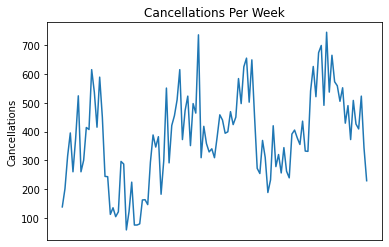

In [ ]:
plt.plot(ts)
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
plt.ylabel('Cancellations')
plt.title("Cancellations Per Week")
plt.show()

In [ ]:
df = pd.DataFrame(ts)
df.head()

,is_canceled
full_date,
201527,138
201528,201
201529,315
201530,395
201531,260


In [ ]:
df = np.array(df,dtype='float32')

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))
df = scaler.fit_transform(df)

In [ ]:
df = torch.FloatTensor(df)

In [ ]:
def createSeqDataset(series,window=10):
  seq = []
  for i in range(len(series)-window):
    features = series[i:i+window]
    label = series[i+window]
    seq.append((features,label))
  return seq

In [ ]:
window_size = 15
df_seq = createSeqDataset(df,window_size)

In [ ]:
df_seq[1]

(tensor([[-0.5837],
         [-0.2518],
         [-0.0189],
         [-0.4119],
         [-0.0742],
         [ 0.3566],
         [-0.4119],
         [-0.2955],
         [ 0.0364],
         [ 0.0160],
         [ 0.6215],
         [ 0.3945],
         [ 0.0393],
         [ 0.5459],
         [ 0.1412]]), tensor([-0.4585]))

In [ ]:
train_size = int(len(df_seq) * 0.8)
val_size = len(df_seq) - train_size
train, val = df_seq[0:train_size], df_seq[train_size:len(df_seq)]

In [ ]:
class timeSeriesModel(nn.Module):
  def __init__(self,input_size=1,num_classes=1,hidden_size=100,num_layers=1,bidir=False):
    super().__init__()

    self.num_classes = num_classes
    self.num_layers = num_layers
    self.input_size = input_size
    self.hidden_size = hidden_size

    self.lstm = nn.LSTM(input_size,hidden_size,num_layers,bidirectional=bidir)
    self.fc = nn.Linear(hidden_size,num_classes)
  
  def forward(self,series):
    h_0 = Variable(torch.zeros(self.num_layers, 1, self.hidden_size))     
    c_0 = Variable(torch.zeros(self.num_layers, 1, self.hidden_size))
    out,(hid,_) = self.lstm(series.view(len(series),1,-1),(h_0,c_0))
    pred = self.fc(out.view(len(series),-1))
    return pred[-1]

In [ ]:
num_epochs = 700
lr = 1e-4
net = timeSeriesModel(hidden_size=4,num_layers=1)
loss_function = nn.SmoothL1Loss()
optimizer = torch.optim.Adam(net.parameters(), lr=lr)
print(net)

timeSeriesModel(
  (lstm): LSTM(1, 4)
  (fc): Linear(in_features=4, out_features=1, bias=True)
)


In [ ]:
# Training the model 
for epoch in range(num_epochs):
  for seq, label in train:
    optimizer.zero_grad()
    out = net(seq)

    # obtain the loss function
    loss = loss_function(out, label)
    
    loss.backward()
    optimizer.step()

  if epoch % 20 == 0:
    print("Epoch: %d, loss: %1.15f" % (epoch, loss.item()))

Epoch: 0, loss: 0.612491250038147
Epoch: 20, loss: 0.404826790094376
Epoch: 40, loss: 0.316042125225067
Epoch: 60, loss: 0.280455201864243
Epoch: 80, loss: 0.263202190399170
Epoch: 100, loss: 0.245492279529572
Epoch: 120, loss: 0.228955954313278
Epoch: 140, loss: 0.215670824050903
Epoch: 160, loss: 0.204918146133423
Epoch: 180, loss: 0.195965275168419
Epoch: 200, loss: 0.188373789191246
Epoch: 220, loss: 0.181846216320992
Epoch: 240, loss: 0.176159903407097
Epoch: 260, loss: 0.171139225363731
Epoch: 280, loss: 0.166644230484962
Epoch: 300, loss: 0.162563323974609
Epoch: 320, loss: 0.158805921673775
Epoch: 340, loss: 0.155301168560982
Epoch: 360, loss: 0.151991769671440
Epoch: 380, loss: 0.148833274841309
Epoch: 400, loss: 0.145788937807083
Epoch: 420, loss: 0.142826646566391
Epoch: 440, loss: 0.139918416738510
Epoch: 460, loss: 0.137038558721542
Epoch: 480, loss: 0.134166851639748
Epoch: 500, loss: 0.131288930773735
Epoch: 520, loss: 0.128401130437851
Epoch: 540, loss: 0.12551121413707

In [ ]:
net.eval()
y_pred = []
y_real = []
for seq, label in train:
  with torch.no_grad():
    y_pred.append(net(seq))
    y_real.append(label)

y_pred = scaler.inverse_transform(np.array(y_pred).reshape(-1, 1))
y_real = scaler.inverse_transform(np.array(y_real).reshape(-1, 1))
err = loss_function(torch.Tensor(y_pred),torch.Tensor(y_real))
err

tensor(81.2887)

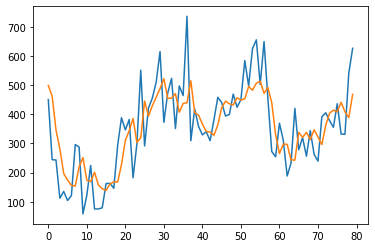

In [ ]:
plt.plot(y_real)
plt.plot(y_pred)

In [ ]:
net.eval()
y_pred = []
y_real = []
for seq, label in val:
  with torch.no_grad():
    y_pred.append(net(seq))
    y_real.append(label)

y_pred = scaler.inverse_transform(np.array(y_pred).reshape(-1, 1))
y_real = scaler.inverse_transform(np.array(y_real).reshape(-1, 1))
err = loss_function(torch.Tensor(y_pred),torch.Tensor(y_real))
err

tensor(93.8487)

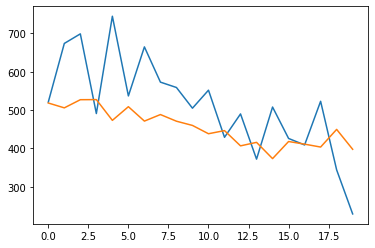

In [ ]:
plt.plot(y_real)
plt.plot(y_pred)